# 17. New Research Questions Analysis

## STAT495 - Turkey Earthquake Analysis Project

This notebook consolidates all new research questions (RQ-NEW-1 through RQ-NEW-14) with their statistical analyses.

### Research Questions Overview

| RQ | Question | Statistical Test |
|---|---|---|
| RQ-NEW-1 | Eclipse vs non-eclipse earthquake rate | Fisher's Exact Test |
| RQ-NEW-2 | Eclipse magnitude effect on major earthquakes | Poisson/Negative Binomial Regression |
| RQ-NEW-3 | Moon illumination predicts major earthquake frequency | Poisson Regression (linear + quadratic) |
| RQ-NEW-4 | Major earthquakes uniform across time-of-day | Chi-square + Standardized Residuals |
| RQ-NEW-5 | Major earthquakes uniform across seasons | Chi-square + Standardized Residuals |
| RQ-NEW-6 | Factors predicting earthquake magnitude | Multiple Linear Regression |
| RQ-NEW-7 | Near-fault lunar/pressure effect on magnitude | Multiple Linear Regression (subset) |
| RQ-NEW-8 | High population + soft soil + high risk overlap | Logistic Regression + VIF |
| RQ-NEW-9 | Regional building age distribution | Kruskal-Wallis + Dunn's post-hoc |
| RQ-NEW-10 | Earthquake vulnerability by old buildings | Spearman + Logistic Regression |
| RQ-NEW-11 | Safety risk (old buildings vs seismic hazard) | Chi-square + Mann-Whitney U |
| RQ-NEW-12 | Combined seismic vulnerability | Logistic Regression |
| RQ-NEW-13 | Earthquake frequency vs building age | Poisson/NB Regression + Spearman |
| RQ-NEW-14 | Fault proximity vs building age | Spearman + Linear Regression |

---
## 1. Setup and Data Loading

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))
from config import *

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
FIGURE_DPI = 150

# Output paths
OUTPUT_DIR = os.path.join(FIGURES_PATH, '17_new_rqs')
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(TABLES_PATH, exist_ok=True)

print('Libraries loaded successfully')
print(f'Output directory: {OUTPUT_DIR}')

Libraries loaded successfully
Output directory: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/figures/17_new_rqs


In [2]:
# Load earthquake data
df = pd.read_csv(os.path.join(DATA_PROCESSED, 'earthquakes_processed.csv'), low_memory=False)
df['date'] = pd.to_datetime(df['date'], format='mixed')
df['date_only'] = df['date'].dt.date

print(f'Earthquake data: {len(df):,} records')
print(f'Date range: {df["date"].min()} to {df["date"].max()}')
print(f'Major earthquakes (M >= 4.0): {(df["magnitude"] >= 4.0).sum():,}')

Earthquake data: 524,952 records
Date range: 1990-01-03 13:30:14 to 2025-11-20 16:51:56
Major earthquakes (M >= 4.0): 4,103


In [3]:
# Load eclipse data
solar_eclipses = pd.read_csv(os.path.join(DATA_RAW, 'lunar', 'solar_eclipses_1990_2025.csv'))
solar_eclipses['date'] = pd.to_datetime(solar_eclipses['date'])

lunar_eclipses = pd.read_csv(os.path.join(DATA_RAW, 'lunar', 'lunar_eclipses_1990_2025.csv'))
lunar_eclipses['date'] = pd.to_datetime(lunar_eclipses['date'])

# Combine eclipse dates
all_eclipse_dates = set(solar_eclipses['date'].dt.date.tolist() + lunar_eclipses['date'].dt.date.tolist())

print(f'Solar eclipses: {len(solar_eclipses)}')
print(f'Lunar eclipses: {len(lunar_eclipses)}')
print(f'Total unique eclipse dates: {len(all_eclipse_dates)}')

Solar eclipses: 79
Lunar eclipses: 82
Total unique eclipse dates: 161


In [4]:
# Create daily counts dataset
daily_counts = df.groupby('date_only').agg({
    'magnitude': ['count', 'mean', 'max']
}).reset_index()
daily_counts.columns = ['date_only', 'eq_count', 'eq_mean_mag', 'eq_max_mag']

# Add eclipse flag
daily_counts['is_eclipse_day'] = daily_counts['date_only'].isin(all_eclipse_dates)
daily_counts['has_major_eq'] = daily_counts['eq_max_mag'] >= 4.0

# Add major earthquake count per day
major_daily = df[df['magnitude'] >= 4.0].groupby('date_only').size()
daily_counts['major_eq_count'] = daily_counts['date_only'].map(major_daily).fillna(0).astype(int)

print(f'Total days: {len(daily_counts):,}')
print(f'Eclipse days: {daily_counts["is_eclipse_day"].sum()}')
print(f'Days with major earthquakes: {daily_counts["has_major_eq"].sum()}')

Total days: 10,496
Eclipse days: 126
Days with major earthquakes: 2294


---
## 2. RQ-NEW-1: Eclipse vs Non-Eclipse Earthquake Rate

**Question:** Is the rate of major earthquakes per day different between eclipse vs non-eclipse days?

**Test:** Fisher's Exact Test (2×2 Contingency Table)

In [5]:
print('='*70)
print('RQ-NEW-1: FISHER\'S EXACT TEST - ECLIPSE vs NON-ECLIPSE DAYS')
print('='*70)

# Contingency table
eclipse_major = daily_counts[daily_counts['is_eclipse_day'] & daily_counts['has_major_eq']].shape[0]
eclipse_no_major = daily_counts[daily_counts['is_eclipse_day'] & ~daily_counts['has_major_eq']].shape[0]
non_eclipse_major = daily_counts[~daily_counts['is_eclipse_day'] & daily_counts['has_major_eq']].shape[0]
non_eclipse_no_major = daily_counts[~daily_counts['is_eclipse_day'] & ~daily_counts['has_major_eq']].shape[0]

contingency_table = np.array([
    [eclipse_major, eclipse_no_major],
    [non_eclipse_major, non_eclipse_no_major]
])

print('\nContingency Table (Days with/without Major Earthquakes):')
print('                    Major EQ    No Major EQ    Total')
print(f'Eclipse Days        {eclipse_major:>8}    {eclipse_no_major:>11}    {eclipse_major + eclipse_no_major:>5}')
print(f'Non-Eclipse Days    {non_eclipse_major:>8}    {non_eclipse_no_major:>11}    {non_eclipse_major + non_eclipse_no_major:>5}')
print(f'Total               {eclipse_major + non_eclipse_major:>8}    {eclipse_no_major + non_eclipse_no_major:>11}    {len(daily_counts):>5}')

# Fisher's Exact Test
odds_ratio, fisher_pvalue = stats.fisher_exact(contingency_table)

print(f'\nFisher\'s Exact Test Results:')
print(f'  Odds Ratio: {odds_ratio:.4f}')
print(f'  p-value: {fisher_pvalue:.4f}')

# Confidence interval
log_or = np.log(odds_ratio) if odds_ratio > 0 else 0
se_log_or = np.sqrt(1/max(eclipse_major,1) + 1/max(eclipse_no_major,1) + 1/max(non_eclipse_major,1) + 1/max(non_eclipse_no_major,1))
ci_lower = np.exp(log_or - 1.96 * se_log_or)
ci_upper = np.exp(log_or + 1.96 * se_log_or)
print(f'  95% CI for OR: ({ci_lower:.4f}, {ci_upper:.4f})')

print('\nInterpretation:')
if fisher_pvalue < 0.05:
    if odds_ratio > 1:
        print('  → SIGNIFICANT: Eclipse days have HIGHER odds of major earthquakes')
    else:
        print('  → SIGNIFICANT: Eclipse days have LOWER odds of major earthquakes')
else:
    print('  → Not significant: No difference in major earthquake probability')

RQ-NEW-1: FISHER'S EXACT TEST - ECLIPSE vs NON-ECLIPSE DAYS

Contingency Table (Days with/without Major Earthquakes):
                    Major EQ    No Major EQ    Total
Eclipse Days              31             95      126
Non-Eclipse Days        2263           8107    10370
Total                   2294           8202    10496

Fisher's Exact Test Results:
  Odds Ratio: 1.1690
  p-value: 0.4484
  95% CI for OR: (0.7773, 1.7581)

Interpretation:
  → Not significant: No difference in major earthquake probability


---
## 3. RQ-NEW-2: Eclipse Magnitude Effect on Major Earthquakes

**Question:** On eclipse days with higher eclipse magnitude, do we observe more major earthquakes?

**Test:** Poisson / Negative Binomial Regression

In [6]:
print('='*70)
print('RQ-NEW-2: ECLIPSE MAGNITUDE EFFECT ON MAJOR EARTHQUAKES')
print('='*70)

# Prepare eclipse day data with magnitude
eclipse_mag_map = {row['date'].date(): row['eclipse_magnitude'] for _, row in solar_eclipses.iterrows()}
daily_counts['eclipse_magnitude'] = daily_counts['date_only'].map(eclipse_mag_map)

# Filter to solar eclipse days with valid magnitude
solar_eclipse_daily = daily_counts[daily_counts['eclipse_magnitude'].notna()].copy()
print(f'\nSolar eclipse days with magnitude data: {len(solar_eclipse_daily)}')

if len(solar_eclipse_daily) > 10:
    y = solar_eclipse_daily['major_eq_count'].values
    X = sm.add_constant(solar_eclipse_daily['eclipse_magnitude'].values)
    
    print(f'\nDependent variable (major_eq_count) statistics:')
    print(f'  Mean: {y.mean():.2f}')
    print(f'  Variance: {y.var():.2f}')
    print(f'  Variance/Mean ratio: {y.var()/max(y.mean(), 0.01):.2f}')
    
    # Fit Poisson model
    try:
        poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
        print(f'\n--- Poisson Regression Results ---')
        print(f'  Eclipse Magnitude coefficient: {poisson_model.params[1]:.4f}')
        print(f'  p-value: {poisson_model.pvalues[1]:.4f}')
        print(f'  Rate Ratio (exp(coef)): {np.exp(poisson_model.params[1]):.4f}')
        
        # Overdispersion check
        dispersion = poisson_model.pearson_chi2 / poisson_model.df_resid
        print(f'\n  Overdispersion ratio: {dispersion:.2f}')
        
        if dispersion > 1.5:
            print('  → Overdispersion detected, fitting Negative Binomial...')
            nb_model = sm.GLM(y, X, family=sm.families.NegativeBinomial(alpha=1.0)).fit()
            print(f'\n--- Negative Binomial Results ---')
            print(f'  Eclipse Magnitude coefficient: {nb_model.params[1]:.4f}')
            print(f'  p-value: {nb_model.pvalues[1]:.4f}')
            final_pval = nb_model.pvalues[1]
            final_coef = nb_model.params[1]
        else:
            final_pval = poisson_model.pvalues[1]
            final_coef = poisson_model.params[1]
        
        print('\nInterpretation:')
        if final_pval < 0.05:
            direction = "MORE" if final_coef > 0 else "FEWER"
            print(f'  → SIGNIFICANT: Higher eclipse magnitude → {direction} major earthquakes')
        else:
            print('  → Not significant: Eclipse magnitude does not predict major earthquake frequency')
    except Exception as e:
        print(f'\nModel error: {e}')
else:
    print('\nInsufficient data for analysis')

RQ-NEW-2: ECLIPSE MAGNITUDE EFFECT ON MAJOR EARTHQUAKES

Solar eclipse days with magnitude data: 59

Dependent variable (major_eq_count) statistics:
  Mean: 0.14
  Variance: 0.12
  Variance/Mean ratio: 0.86

--- Poisson Regression Results ---
  Eclipse Magnitude coefficient: -0.1615
  p-value: 0.9427
  Rate Ratio (exp(coef)): 0.8508

  Overdispersion ratio: 0.89

Interpretation:
  → Not significant: Eclipse magnitude does not predict major earthquake frequency


---
## 4. RQ-NEW-3: Moon Illumination Predicts Major Earthquake Frequency

**Question:** Does moon illumination predict major earthquake frequency?

**Test:** Poisson Regression (linear and quadratic/U-shaped)

In [7]:
print('='*70)
print('RQ-NEW-3: MOON ILLUMINATION PREDICTS MAJOR EARTHQUAKE FREQUENCY')
print('='*70)

# Prepare daily data with illumination
daily_illum = df.groupby('date_only').agg({
    'illumination': 'first'
}).reset_index()

daily_moon = daily_counts.merge(daily_illum, on='date_only', how='left')
daily_moon = daily_moon[daily_moon['illumination'].notna()]

print(f'\nDays with illumination data: {len(daily_moon):,}')

y = daily_moon['major_eq_count'].values
illum = daily_moon['illumination'].values / 100  # Scale to 0-1

# Model 1: Linear
X_linear = sm.add_constant(illum)
print('\n--- Model 1: Linear ---')
try:
    model_linear = sm.GLM(y, X_linear, family=sm.families.Poisson()).fit()
    print(f'  Illumination coefficient: {model_linear.params[1]:.4f}')
    print(f'  p-value: {model_linear.pvalues[1]:.4f}')
    print(f'  AIC: {model_linear.aic:.2f}')
    aic_linear = model_linear.aic
except Exception as e:
    print(f'  Error: {e}')
    aic_linear = np.inf

# Model 2: Quadratic
illum_sq = illum ** 2
X_quad = np.column_stack([np.ones(len(illum)), illum, illum_sq])
print('\n--- Model 2: Quadratic (U-shaped) ---')
try:
    model_quad = sm.GLM(y, X_quad, family=sm.families.Poisson()).fit()
    print(f'  Illumination coefficient: {model_quad.params[1]:.4f}')
    print(f'  Illumination² coefficient: {model_quad.params[2]:.4f}')
    print(f'  p-values: illum={model_quad.pvalues[1]:.4f}, illum²={model_quad.pvalues[2]:.4f}')
    print(f'  AIC: {model_quad.aic:.2f}')
    aic_quad = model_quad.aic
except Exception as e:
    print(f'  Error: {e}')
    aic_quad = np.inf

print('\n--- Model Comparison ---')
print(f'  AIC Linear: {aic_linear:.2f}')
print(f'  AIC Quadratic: {aic_quad:.2f}')
best_model = 'Linear' if aic_linear < aic_quad else 'Quadratic'
print(f'  → {best_model} model is preferred (lower AIC)')

print('\nInterpretation:')
if aic_linear != np.inf and model_linear.pvalues[1] < 0.05:
    direction = "MORE" if model_linear.params[1] > 0 else "FEWER"
    print(f'  → SIGNIFICANT: Higher illumination (full moon) → {direction} major earthquakes')
else:
    print('  → Not significant: Moon illumination does not predict major earthquake frequency')

RQ-NEW-3: MOON ILLUMINATION PREDICTS MAJOR EARTHQUAKE FREQUENCY

Days with illumination data: 10,496

--- Model 1: Linear ---
  Illumination coefficient: 0.3207
  p-value: 0.0000
  AIC: 22809.29

--- Model 2: Quadratic (U-shaped) ---
  Illumination coefficient: -0.9619
  Illumination² coefficient: 1.2573
  p-values: illum=0.0000, illum²=0.0000
  AIC: 22761.44

--- Model Comparison ---
  AIC Linear: 22809.29
  AIC Quadratic: 22761.44
  → Quadratic model is preferred (lower AIC)

Interpretation:
  → SIGNIFICANT: Higher illumination (full moon) → MORE major earthquakes


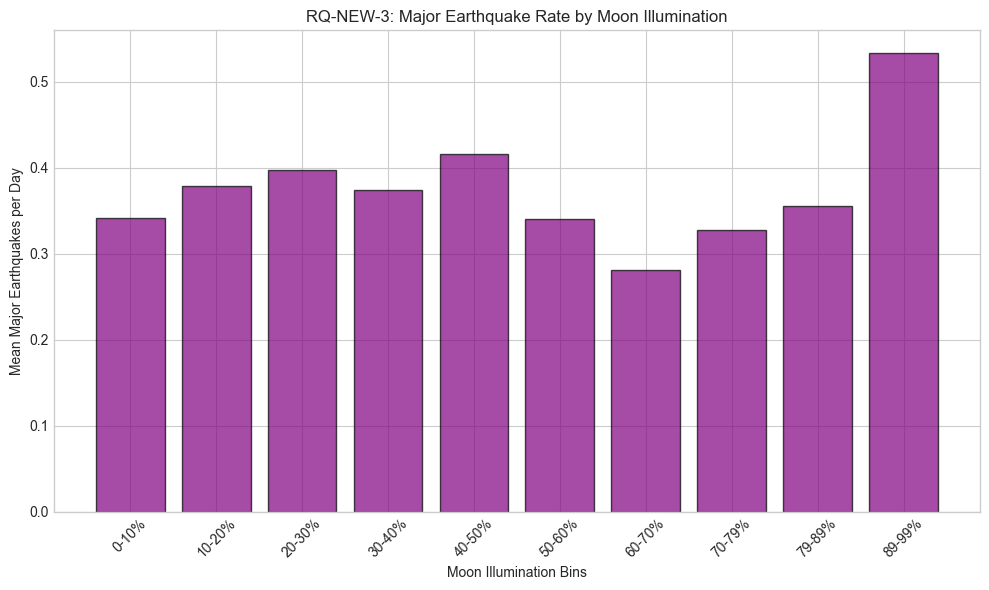

In [8]:
# Visualization for RQ-NEW-3
fig, ax = plt.subplots(figsize=(10, 6))

illum_bins = pd.cut(daily_moon['illumination'], bins=10)
bin_stats = daily_moon.groupby(illum_bins)['major_eq_count'].mean()

ax.bar(range(len(bin_stats)), bin_stats.values, color='purple', alpha=0.7, edgecolor='black')
ax.set_xlabel('Moon Illumination Bins')
ax.set_ylabel('Mean Major Earthquakes per Day')
ax.set_title('RQ-NEW-3: Major Earthquake Rate by Moon Illumination')
ax.set_xticks(range(len(bin_stats)))
ax.set_xticklabels([f'{int(b.left)}-{int(b.right)}%' for b in bin_stats.index], rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'rq3_moon_illumination.png'), dpi=FIGURE_DPI, bbox_inches='tight')
plt.show()

---
## 5. RQ-NEW-4: Major Earthquakes Uniform Across Time-of-Day

**Question:** Are major earthquakes uniformly distributed across time-of-day bins?

**Test:** Chi-square Goodness-of-Fit + Standardized Residuals

In [9]:
print('='*70)
print('RQ-NEW-4: MAJOR EARTHQUAKES ACROSS TIME-OF-DAY BINS')
print('='*70)

# Create time bins
def get_time_bin(hour):
    if hour < 4: return '00-04'
    elif hour < 8: return '04-08'
    elif hour < 12: return '08-12'
    elif hour < 16: return '12-16'
    elif hour < 20: return '16-20'
    else: return '20-24'

major_eq = df[df['magnitude'] >= 4.0].copy()
major_eq['time_bin'] = major_eq['hour'].apply(get_time_bin)

time_bin_counts = major_eq['time_bin'].value_counts().sort_index()
n_bins = 6
expected = len(major_eq) / n_bins

print(f'\nTotal major earthquakes (M >= 4.0): {len(major_eq):,}')
print(f'Expected per bin (uniform): {expected:.1f}')
print(f'\nObserved counts by time-of-day:')
for bin_name, count in time_bin_counts.items():
    print(f'  {bin_name}: {count}')

# Chi-square test
chi2, p_value = stats.chisquare(time_bin_counts.values)
print(f'\nChi-square Goodness-of-Fit Test:')
print(f'  Chi² = {chi2:.4f}')
print(f'  p-value = {p_value:.4e}')

# Standardized residuals
print(f'\nStandardized Residuals (|SR| > 2 = significant):')
for bin_name, obs in time_bin_counts.items():
    sr = (obs - expected) / np.sqrt(expected)
    sig = "***" if abs(sr) > 2 else ""
    print(f'  {bin_name}: SR = {sr:+.2f} {sig}')

print('\nInterpretation:')
if p_value < 0.05:
    print('  → SIGNIFICANT: Major earthquakes NOT uniformly distributed across time-of-day')
else:
    print('  → Not significant: Major earthquakes appear uniform across time-of-day')

RQ-NEW-4: MAJOR EARTHQUAKES ACROSS TIME-OF-DAY BINS

Total major earthquakes (M >= 4.0): 4,103
Expected per bin (uniform): 683.8

Observed counts by time-of-day:
  00-04: 631
  04-08: 683
  08-12: 730
  12-16: 695
  16-20: 696
  20-24: 668

Chi-square Goodness-of-Fit Test:
  Chi² = 7.9651
  p-value = 1.5817e-01

Standardized Residuals (|SR| > 2 = significant):
  00-04: SR = -2.02 ***
  04-08: SR = -0.03 
  08-12: SR = +1.77 
  12-16: SR = +0.43 
  16-20: SR = +0.47 
  20-24: SR = -0.61 

Interpretation:
  → Not significant: Major earthquakes appear uniform across time-of-day


---
## 6. RQ-NEW-5: Major Earthquakes Uniform Across Seasons

**Question:** Are major earthquakes uniformly distributed across seasons?

**Test:** Chi-square Goodness-of-Fit + Standardized Residuals

In [10]:
print('='*70)
print('RQ-NEW-5: MAJOR EARTHQUAKES ACROSS SEASONS')
print('='*70)

# Create season mapping
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Fall'

major_eq['season'] = major_eq['month'].apply(get_season)

season_order = ['Winter', 'Spring', 'Summer', 'Fall']
season_counts = major_eq['season'].value_counts().reindex(season_order)
expected_season = len(major_eq) / 4

print(f'\nTotal major earthquakes: {len(major_eq):,}')
print(f'Expected per season (uniform): {expected_season:.1f}')
print(f'\nObserved counts by season:')
for season, count in season_counts.items():
    print(f'  {season}: {count}')

# Chi-square test
chi2_season, p_value_season = stats.chisquare(season_counts.values)
print(f'\nChi-square Goodness-of-Fit Test:')
print(f'  Chi² = {chi2_season:.4f}')
print(f'  p-value = {p_value_season:.4e}')

# Standardized residuals
print(f'\nStandardized Residuals:')
for season, obs in season_counts.items():
    sr = (obs - expected_season) / np.sqrt(expected_season)
    sig = "***" if abs(sr) > 2 else ""
    print(f'  {season}: SR = {sr:+.2f} {sig}')

print('\nInterpretation:')
if p_value_season < 0.05:
    print('  → SIGNIFICANT: Major earthquakes NOT uniformly distributed across seasons')
else:
    print('  → Not significant: Major earthquakes appear uniform across seasons')

RQ-NEW-5: MAJOR EARTHQUAKES ACROSS SEASONS

Total major earthquakes: 4,103
Expected per season (uniform): 1025.8

Observed counts by season:
  Winter: 1431
  Spring: 873
  Summer: 864
  Fall: 935

Chi-square Goodness-of-Fit Test:
  Chi² = 216.3868
  p-value = 1.2127e-46

Standardized Residuals:
  Winter: SR = +12.65 ***
  Spring: SR = -4.77 ***
  Summer: SR = -5.05 ***
  Fall: SR = -2.83 ***

Interpretation:
  → SIGNIFICANT: Major earthquakes NOT uniformly distributed across seasons


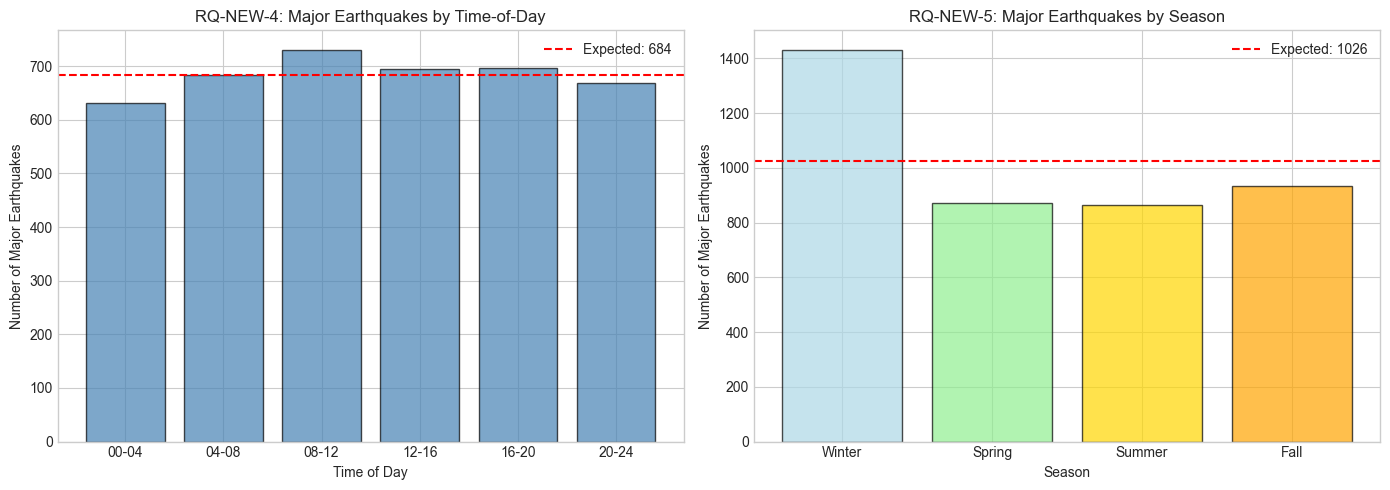

In [11]:
# Visualization for RQ-NEW-4 and RQ-NEW-5
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time-of-day
axes[0].bar(time_bin_counts.index, time_bin_counts.values, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axhline(y=expected, color='red', linestyle='--', label=f'Expected: {expected:.0f}')
axes[0].set_xlabel('Time of Day')
axes[0].set_ylabel('Number of Major Earthquakes')
axes[0].set_title('RQ-NEW-4: Major Earthquakes by Time-of-Day')
axes[0].legend()

# Seasonal
colors_season = ['lightblue', 'lightgreen', 'gold', 'orange']
axes[1].bar(season_counts.index, season_counts.values, color=colors_season, alpha=0.7, edgecolor='black')
axes[1].axhline(y=expected_season, color='red', linestyle='--', label=f'Expected: {expected_season:.0f}')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Number of Major Earthquakes')
axes[1].set_title('RQ-NEW-5: Major Earthquakes by Season')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'rq4_rq5_time_season.png'), dpi=FIGURE_DPI, bbox_inches='tight')
plt.show()

---
## 7. RQ-NEW-6: Factors Predicting Earthquake Magnitude

**Question:** Which factors—depth, fault distance, geology type, tectonic setting—best predict earthquake magnitude?

**Test:** Multiple Linear Regression

In [12]:
print('='*70)
print('RQ-NEW-6: FACTORS PREDICTING EARTHQUAKE MAGNITUDE')
print('='*70)

# Prepare dataset
model_data = df[['magnitude', 'depth', 'fault_distance_km', 'geology_type', 'tectonic_setting']].dropna()
print(f'\nRecords with complete data: {len(model_data):,}')

if len(model_data) > 100:
    # Encode categorical variables
    geology_dummies = pd.get_dummies(model_data['geology_type'], prefix='geo', drop_first=True)
    tectonic_dummies = pd.get_dummies(model_data['tectonic_setting'], prefix='tect', drop_first=True)
    
    X = pd.concat([
        model_data[['depth', 'fault_distance_km']].reset_index(drop=True),
        geology_dummies.reset_index(drop=True),
        tectonic_dummies.reset_index(drop=True)
    ], axis=1).astype(float)
    X = sm.add_constant(X)
    y = model_data['magnitude'].values
    
    # Fit model
    model_full = sm.OLS(y, X).fit()
    print('\n--- Full Model Results ---')
    print(model_full.summary())
    
    # VIF check
    print('\n--- VIF Check ---')
    vif_data = pd.DataFrame()
    vif_data['Variable'] = X.columns[1:]
    try:
        vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(1, X.shape[1])]
        print(vif_data.to_string(index=False))
    except:
        print('VIF calculation skipped')
    
    print('\n--- Interpretation ---')
    print(f'R² = {model_full.rsquared:.4f} (explains {100*model_full.rsquared:.1f}% of variance)')
    print(f'\nSignificant predictors (p < 0.05):')
    for var, coef, pval in zip(model_full.params.index, model_full.params.values, model_full.pvalues.values):
        if pval < 0.05 and var != 'const':
            direction = "increases" if coef > 0 else "decreases"
            print(f'  {var}: β={coef:.4f} → {direction} magnitude')
else:
    print('Insufficient data')

RQ-NEW-6: FACTORS PREDICTING EARTHQUAKE MAGNITUDE



Records with complete data: 3,907

--- Full Model Results ---
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.289
Date:                Fri, 16 Jan 2026   Prob (F-statistic):           0.000953
Time:                        16:14:07   Log-Likelihood:                -1933.2
No. Observations:                3907   AIC:                             3884.
Df Residuals:                    3898   BIC:                             3941.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

                 Variable      VIF
                    depth 1.087147
        fault_distance_km 1.250208
   geo_Limestone/alluvium      inf
 geo_Metamorphic/volcanic      inf
   geo_Sedimentary basins      inf
geo_Sedimentary/limestone      inf
 geo_Volcanic/metamorphic      inf
     geo_Volcanic/plateau      inf
          tect_Active NAF      inf
    tect_Active collision      inf
    tect_Active extension      inf
                 tect_Low      inf
            tect_Moderate      inf
              tect_Stable      inf

--- Interpretation ---
R² = 0.0067 (explains 0.7% of variance)

Significant predictors (p < 0.05):
  depth: β=0.0027 → increases magnitude
  geo_Limestone/alluvium: β=0.3895 → increases magnitude
  geo_Metamorphic/volcanic: β=0.3886 → increases magnitude
  geo_Sedimentary basins: β=0.3942 → increases magnitude
  geo_Sedimentary/limestone: β=0.7975 → increases magnitude
  geo_Volcanic/metamorphic: β=0.4037 → increases magnitude
  geo_Volcanic/plateau: β=0.3904 → increase

---
## 8. RQ-NEW-7: Near-Fault Lunar/Pressure Effect on Magnitude

**Question:** Among earthquakes within 50km of active fault, do lunar phase or atmospheric pressure explain magnitude variation after controlling for depth?

**Test:** Multiple Linear Regression (subset analysis)

In [13]:
print('='*70)
print('RQ-NEW-7: NEAR-FAULT LUNAR/PRESSURE EFFECT ON MAGNITUDE')
print('='*70)

# Filter to earthquakes within 50km of fault
near_fault = df[df['fault_distance_km'] <= 50].copy()
print(f'\nEarthquakes within 50km of fault: {len(near_fault):,}')

model_data = near_fault[['magnitude', 'depth', 'moon_phase', 'pressure_hpa']].dropna()
print(f'Records with complete data: {len(model_data):,}')

if len(model_data) > 100:
    # Encode moon phase
    moon_dummies = pd.get_dummies(model_data['moon_phase'], prefix='moon', drop_first=True)
    
    X = pd.concat([
        model_data[['depth', 'pressure_hpa']].reset_index(drop=True).astype(float),
        moon_dummies.reset_index(drop=True).astype(float)
    ], axis=1)
    X = sm.add_constant(X)
    y = model_data['magnitude'].values
    
    model_near = sm.OLS(y, X).fit()
    print('\n--- Near-Fault Model Results ---')
    print(model_near.summary())
    
    print('\n--- Interpretation ---')
    print(f'R² = {model_near.rsquared:.4f}')
    print(f'\nAmong near-fault earthquakes:')
    
    sig_found = False
    for var, coef, pval in zip(model_near.params.index, model_near.params.values, model_near.pvalues.values):
        if pval < 0.05 and var != 'const':
            direction = "increases" if coef > 0 else "decreases"
            print(f'  {var}: β={coef:.4f} → {direction} magnitude')
            sig_found = True
    
    if not sig_found:
        print('  No moon phase or pressure variables significantly predict magnitude')
else:
    print('Insufficient near-fault data')

RQ-NEW-7: NEAR-FAULT LUNAR/PRESSURE EFFECT ON MAGNITUDE

Earthquakes within 50km of fault: 1,329
Records with complete data: 1,329

--- Near-Fault Model Results ---
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.452
Date:                Fri, 16 Jan 2026   Prob (F-statistic):            0.00419
Time:                        16:14:07   Log-Likelihood:                -740.47
No. Observations:                1329   AIC:                             1493.
Df Residuals:                    1323   BIC:                             1524.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          

---
## 9. RQ-NEW-8: High Population + Soft Soil + High Risk Overlap

**Question:** Do highly populated areas with soft soils coincide with zones of high seismic hazard AND high liquefaction risk?

**Test:** Logistic Regression with VIF check

In [14]:
print('='*70)
print('RQ-NEW-8: HIGH POPULATION + SOFT SOIL + HIGH RISK OVERLAP')
print('='*70)

# Define high risk
high_hazard = df['seismic_hazard'].isin(['Very High', 'High'])
high_liquefaction = df['liquefaction_risk'].isin(['Very High', 'High'])
df['high_risk'] = (high_hazard & high_liquefaction).astype(int)

print(f'\nHigh Risk Definition:')
print(f'  Seismic hazard in (Very High, High) AND Liquefaction risk in (Very High, High)')
print(f'\nHigh risk events: {df["high_risk"].sum():,} ({100*df["high_risk"].mean():.1f}%)')

# Prepare analysis dataset
analysis_df = df[['high_risk', 'population_density', 'vs30', 'soil_class']].dropna().copy()
print(f'Records with complete data: {len(analysis_df):,}')

# Create population density bins
analysis_df['pop_bin'] = pd.cut(analysis_df['population_density'],
                                bins=[0, 50, 100, 200, 500, np.inf],
                                labels=['<50', '50-100', '100-200', '200-500', '>500'])

# Prepare predictors
pop_dummies = pd.get_dummies(analysis_df['pop_bin'], prefix='pop', drop_first=True).astype(float)
X = pd.concat([pop_dummies.reset_index(drop=True), 
               analysis_df[['vs30']].reset_index(drop=True).astype(float)], axis=1)
X = sm.add_constant(X)
y = analysis_df['high_risk'].values.astype(float)

# VIF check
print('\n--- VIF Check ---')
try:
    vif_data = pd.DataFrame()
    vif_data['Variable'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif_data.to_string(index=False))
except Exception as e:
    print(f'VIF error: {e}')

# Fit logistic regression
print('\n--- Logistic Regression ---')
try:
    logit_model = sm.Logit(y, X).fit(disp=0, maxiter=100)
    
    # Print full model summary
    print('\n--- Logistic Regression Summary ---')
    print(logit_model.summary())
    
    # Odds ratios
    print('\n--- Odds Ratios ---')
    odds_ratios = np.exp(logit_model.params)
    ci = logit_model.conf_int()
    ci_odds = np.exp(ci)
    
    or_df = pd.DataFrame({
        'Variable': X.columns,
        'Odds Ratio': odds_ratios.values,
        'p-value': logit_model.pvalues.values,
        '95% CI Lower': ci_odds[0].values,
        '95% CI Upper': ci_odds[1].values
    })
    print(or_df.to_string(index=False))
    
    print('\nInterpretation:')
    for _, row in or_df.iterrows():
        if row['p-value'] < 0.05 and row['Variable'] != 'const':
            direction = "INCREASES" if row['Odds Ratio'] > 1 else "DECREASES"
            print(f'  {row["Variable"]}: OR={row["Odds Ratio"]:.2f} → {direction} high risk odds')
except Exception as e:
    print(f'Model error: {e}')

RQ-NEW-8: HIGH POPULATION + SOFT SOIL + HIGH RISK OVERLAP

High Risk Definition:
  Seismic hazard in (Very High, High) AND Liquefaction risk in (Very High, High)

High risk events: 90,648 (17.3%)
Records with complete data: 514,965

--- VIF Check ---


   Variable       VIF
      const 27.416138
 pop_50-100  2.015362
pop_100-200  1.945465
pop_200-500  2.130865
   pop_>500  1.079388
       vs30  1.539623

--- Logistic Regression ---



--- Logistic Regression Summary ---


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               514965
Model:                          Logit   Df Residuals:                   514959
Method:                           MLE   Df Model:                            5
Date:                Fri, 16 Jan 2026   Pseudo R-squ.:                  0.8556
Time:                        16:14:09   Log-Likelihood:                -34588.
converged:                      False   LL-Null:                   -2.3958e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          32.8438      0.236    139.092      0.000      32.381      33.307
pop_50-100      1.0058      0.136      7.397      0.000       0.739       1.272
pop_100-200     2.8930      0.135     21.488    

---
## 10. RQ-NEW-9: Regional Building Age Comparison (EDA)

**Question:** "How does the age distribution of buildings vary across different regions of Türkiye?"

**Method:** Kruskal-Wallis test + Dunn's post-hoc test

**Data Source:** TÜİK Building Age by Province (2023)

RQ-NEW-9: REGIONAL BUILDING AGE COMPARISON

Loaded building age data: 81 provinces

--- Building Age Distribution by Region ---
                   Mean %  Std %  Min %  Max %  Total Households
region                                                          
Akdeniz             13.81   5.15   7.39  22.97           3231267
Doğu Anadolu        11.43   5.72   2.67  20.44           1503883
Ege                 17.00   2.83  13.96  21.78           4077235
Güneydoğu Anadolu    7.39   2.59   2.60  11.15           1992288
Karadeniz           18.83   4.36  11.32  26.16           2626607
Marmara             12.82   4.74   6.40  20.74           7631732
İç Anadolu          15.97   3.75  10.29  21.45           4266821

--- Kruskal-Wallis Test ---
H-statistic: 34.0151
P-value: 6.6823e-06
Conclusion: Significant regional differences (α=0.05)

--- Dunn's Post-hoc Test (Bonferroni corrected) ---
Significant pairwise differences:
  Doğu Anadolu vs Karadeniz: p=0.0061
  Ege vs Güneydoğu Anadolu: p=0.0032
 

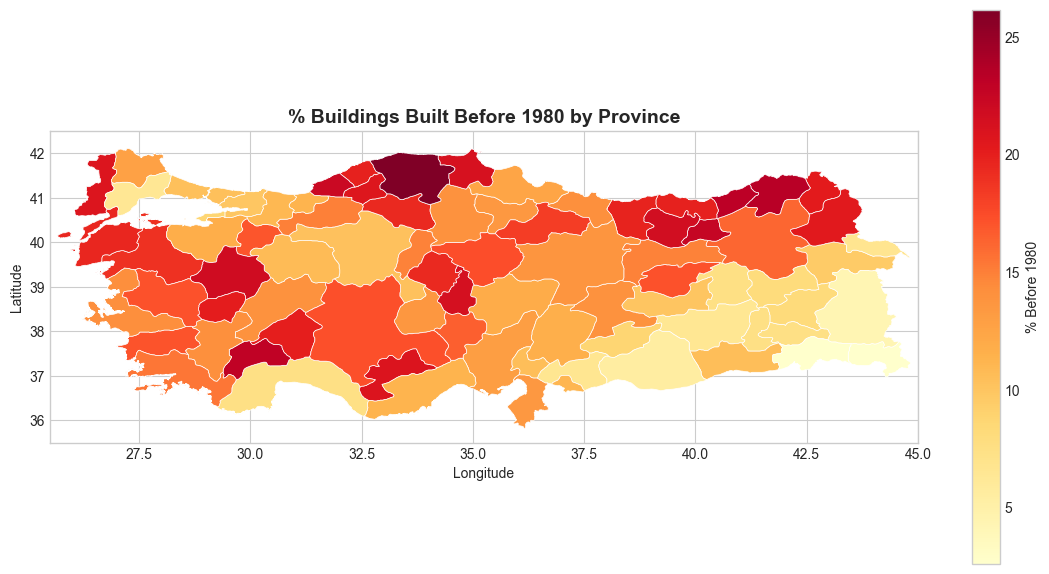

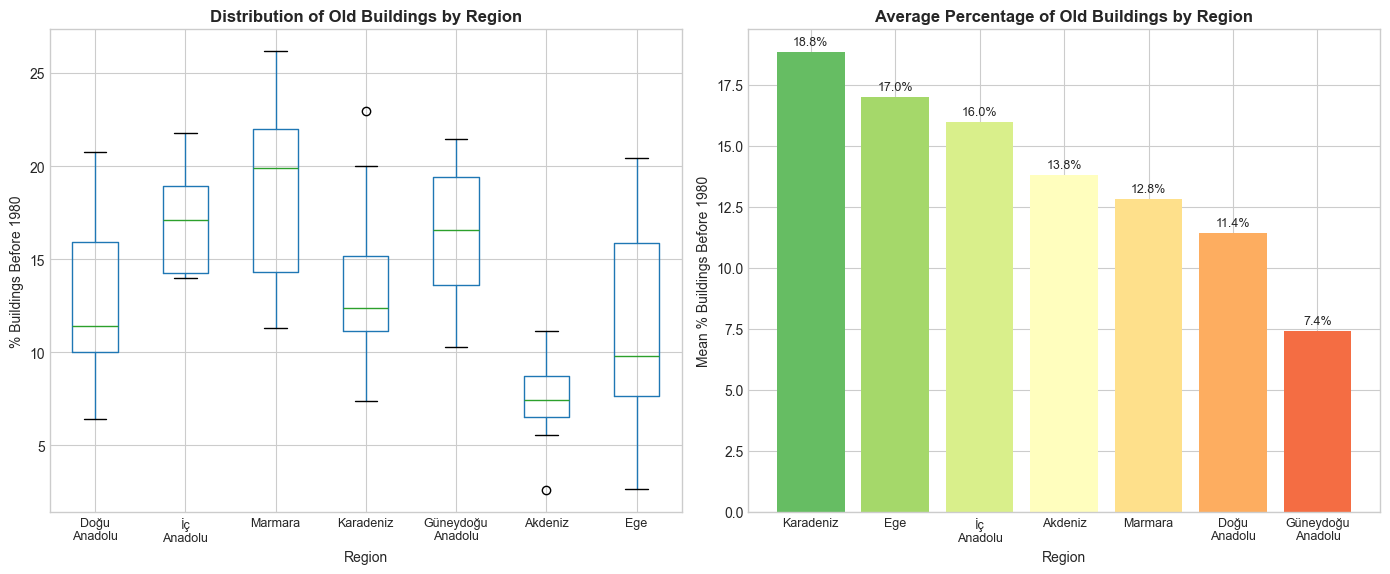

In [15]:
print('='*70)
print('RQ-NEW-9: REGIONAL BUILDING AGE COMPARISON')
print('='*70)

# Load building age data
building_df = pd.read_csv(os.path.join(DATA_PROCESSED, 'building_age_processed.csv'))
print(f"\nLoaded building age data: {len(building_df)} provinces")

# Display summary by region
print("\n--- Building Age Distribution by Region ---")
region_summary = building_df.groupby('region').agg({
    'pct_before_1980': ['mean', 'std', 'min', 'max'],
    'total': 'sum'
}).round(2)
region_summary.columns = ['Mean %', 'Std %', 'Min %', 'Max %', 'Total Households']
print(region_summary)

# Kruskal-Wallis Test
print("\n--- Kruskal-Wallis Test ---")
regions = building_df['region'].unique()
groups = [building_df[building_df['region'] == r]['pct_before_1980'].values for r in regions]

h_stat, p_value = stats.kruskal(*groups)
print(f"H-statistic: {h_stat:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Conclusion: {'Significant regional differences' if p_value < 0.05 else 'No significant differences'} (α=0.05)")

# Post-hoc Dunn's test if significant
if p_value < 0.05:
    from scikit_posthocs import posthoc_dunn
    print("\n--- Dunn's Post-hoc Test (Bonferroni corrected) ---")
    dunn_result = posthoc_dunn(building_df, val_col='pct_before_1980', group_col='region', p_adjust='bonferroni')
    # Show significant pairs
    sig_pairs = []
    for i in range(len(dunn_result)):
        for j in range(i+1, len(dunn_result.columns)):
            if dunn_result.iloc[i, j] < 0.05:
                sig_pairs.append(f"{dunn_result.index[i]} vs {dunn_result.columns[j]}: p={dunn_result.iloc[i, j]:.4f}")
    if sig_pairs:
        print("Significant pairwise differences:")
        for pair in sig_pairs:
            print(f"  {pair}")
    else:
        print("No significant pairwise differences after Bonferroni correction")

# Import visualization functions for Turkey maps
import sys
sys.path.insert(0, '../src')
from visualization import create_turkey_choropleth, plot_province_categories

# Figure 1: Choropleth map of % buildings before 1980
fig1, ax1 = create_turkey_choropleth(
    building_df, 
    value_column='pct_before_1980',
    province_column='province',
    cmap='YlOrRd',
    figsize=(14, 9),
    title='% Buildings Built Before 1980 by Province',
    legend_label='% Before 1980'
)
plt.savefig(os.path.join(OUTPUT_DIR, 'rq9_building_age_map.png'), dpi=300, bbox_inches='tight')
plt.show()

# Figure 2: Box plot and bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Box plot
ax1 = axes[0]
region_order = building_df.groupby('region')['pct_before_1980'].median().sort_values(ascending=False).index
building_df.boxplot(column='pct_before_1980', by='region', ax=ax1, 
                    positions=[list(region_order).index(r) for r in building_df['region'].unique()])
ax1.set_xticklabels([r.replace(' ', '\n') for r in region_order], rotation=0, fontsize=9)
ax1.set_xlabel('Region')
ax1.set_ylabel('% Buildings Before 1980')
ax1.set_title('Distribution of Old Buildings by Region', fontweight='bold')
plt.suptitle('')

# Bar chart - mean percentage by region
ax2 = axes[1]
region_means = building_df.groupby('region')['pct_before_1980'].mean().sort_values(ascending=False)
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(region_means)))
bars = ax2.bar(range(len(region_means)), region_means.values, color=colors)
ax2.set_xticks(range(len(region_means)))
ax2.set_xticklabels([r.replace(' ', '\n') for r in region_means.index], rotation=0, fontsize=9)
ax2.set_xlabel('Region')
ax2.set_ylabel('Mean % Buildings Before 1980')
ax2.set_title('Average Percentage of Old Buildings by Region', fontweight='bold')

# Add value labels
for bar, val in zip(bars, region_means.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
             f'{val:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'rq9_regional_building_age.png'), dpi=300, bbox_inches='tight')
plt.show()

---
## 11. RQ-NEW-10: Earthquake Vulnerability by Building Age

**Question:** "Do provinces with older housing stock (1980 and before) have higher earthquake vulnerability?"

**Method:** Spearman correlation + Logistic regression

**Hypothesis:** Provinces with higher % of old buildings should have higher seismic hazard classification

RQ-NEW-10: EARTHQUAKE VULNERABILITY BY BUILDING AGE

Seismic Hazard Distribution:
seismic_hazard
High         37
Medium       27
Very High    17
Name: count, dtype: int64

High Seismic Zone (Very High + High): 54 provinces

--- % Old Buildings by Seismic Hazard Level ---
                count   mean   std  median
seismic_hazard                            
High               37  13.49  5.70   13.96
Medium             27  18.13  4.27   19.41
Very High          17  10.36  2.94   10.37

--- Spearman Correlation ---
Spearman rho: -0.5279
P-value: 0.0000

--- Logistic Regression: High Seismic ~ % Old Buildings ---
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.2799      1.007      4.249      0.000       2.306       6.254
pct_before_1980    -0.2323      0.059     -3.904      0.000      -0.349      -0.116

Odds Ratio (per 1% increase in old buildings): 

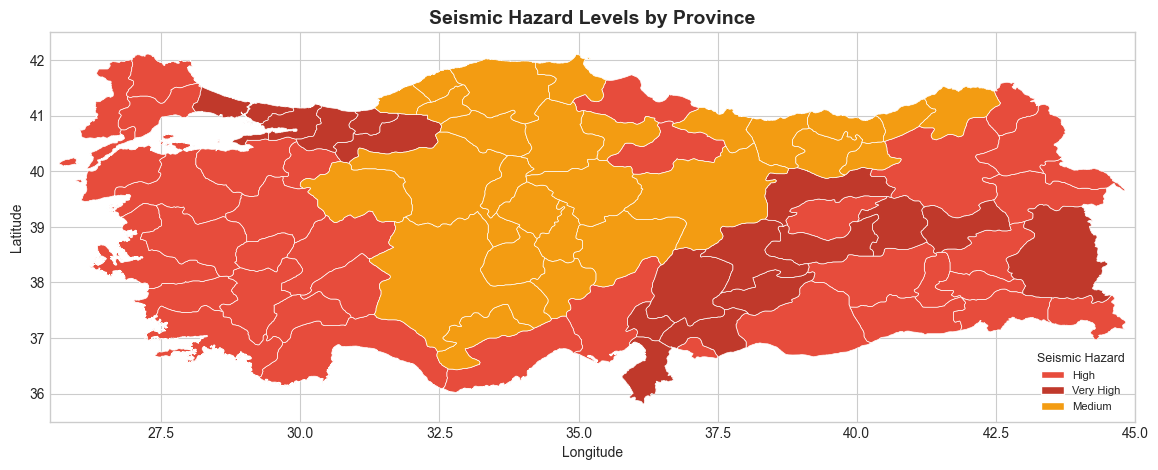

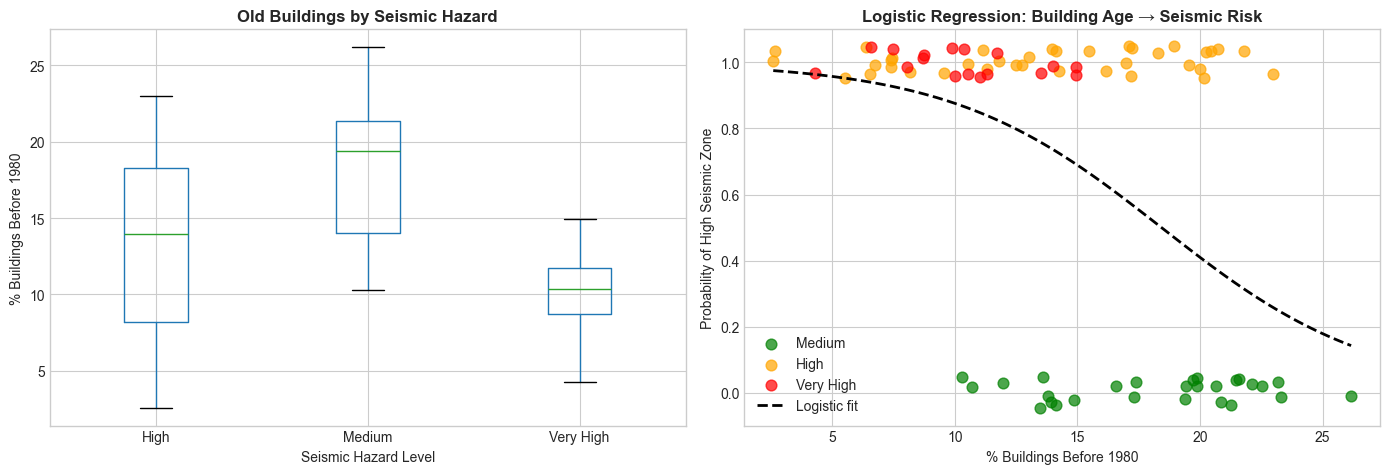

In [16]:
print('='*70)
print('RQ-NEW-10: EARTHQUAKE VULNERABILITY BY BUILDING AGE')
print('='*70)

# Create high seismic hazard indicator (Very High OR High)
building_df['high_seismic'] = building_df['seismic_hazard'].isin(['Very High', 'High']).astype(int)

print(f"\nSeismic Hazard Distribution:")
print(building_df['seismic_hazard'].value_counts())
print(f"\nHigh Seismic Zone (Very High + High): {building_df['high_seismic'].sum()} provinces")

# Descriptive stats by seismic hazard
print("\n--- % Old Buildings by Seismic Hazard Level ---")
hazard_stats = building_df.groupby('seismic_hazard')['pct_before_1980'].agg(['count', 'mean', 'std', 'median'])
print(hazard_stats.round(2))

# Spearman correlation
# Create ordinal encoding for seismic hazard
hazard_order = {'Medium': 1, 'High': 2, 'Very High': 3}
building_df['seismic_hazard_ord'] = building_df['seismic_hazard'].map(hazard_order)

rho, p_spearman = stats.spearmanr(building_df['pct_before_1980'], building_df['seismic_hazard_ord'])
print(f"\n--- Spearman Correlation ---")
print(f"Spearman rho: {rho:.4f}")
print(f"P-value: {p_spearman:.4f}")

# Logistic Regression: high_seismic ~ pct_before_1980
print("\n--- Logistic Regression: High Seismic ~ % Old Buildings ---")
X = sm.add_constant(building_df[['pct_before_1980']])
y = building_df['high_seismic']

logit_model = sm.Logit(y, X).fit(disp=0)
print(logit_model.summary().tables[1])

# Odds ratio
odds_ratio = np.exp(logit_model.params['pct_before_1980'])
ci = np.exp(logit_model.conf_int().loc['pct_before_1980'])
print(f"\nOdds Ratio (per 1% increase in old buildings): {odds_ratio:.4f}")
print(f"95% CI: ({ci[0]:.4f}, {ci[1]:.4f})")
print(f"P-value: {logit_model.pvalues['pct_before_1980']:.4f}")

# Interpretation
if logit_model.pvalues['pct_before_1980'] < 0.05:
    direction = "increases" if odds_ratio > 1 else "decreases"
    print(f"\nInterpretation: Each 1% increase in old buildings {direction} odds of high seismic zone by {abs(odds_ratio-1)*100:.1f}%")

# Figure 1: Seismic hazard choropleth map
from visualization import plot_province_categories, HAZARD_COLORS
hazard_colors = {
    'Very High': '#c0392b',
    'High': '#e74c3c', 
    'Medium': '#f39c12'
}
fig1, ax1 = plot_province_categories(
    building_df,
    category_column='seismic_hazard',
    province_column='province',
    color_map=hazard_colors,
    figsize=(14, 9),
    title='Seismic Hazard Levels by Province',
    legend_title='Seismic Hazard'
)
plt.savefig(os.path.join(OUTPUT_DIR, 'rq10_seismic_hazard_map.png'), dpi=300, bbox_inches='tight')
plt.show()

# Figure 2: Box plot and scatter
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
ax1 = axes[0]
building_df.boxplot(column='pct_before_1980', by='seismic_hazard', ax=ax1)
ax1.set_xlabel('Seismic Hazard Level')
ax1.set_ylabel('% Buildings Before 1980')
ax1.set_title('Old Buildings by Seismic Hazard', fontweight='bold')
plt.suptitle('')

# Scatter with logistic curve
ax2 = axes[1]
colors = {'Medium': 'green', 'High': 'orange', 'Very High': 'red'}
for hazard in ['Medium', 'High', 'Very High']:
    subset = building_df[building_df['seismic_hazard'] == hazard]
    ax2.scatter(subset['pct_before_1980'], subset['high_seismic'] + np.random.uniform(-0.05, 0.05, len(subset)),
                c=colors[hazard], label=hazard, alpha=0.7, s=60)

# Add logistic curve
x_range = np.linspace(building_df['pct_before_1980'].min(), building_df['pct_before_1980'].max(), 100)
X_pred = sm.add_constant(pd.DataFrame({'pct_before_1980': x_range}))
y_pred = logit_model.predict(X_pred)
ax2.plot(x_range, y_pred, 'k--', linewidth=2, label='Logistic fit')

ax2.set_xlabel('% Buildings Before 1980')
ax2.set_ylabel('Probability of High Seismic Zone')
ax2.set_title('Logistic Regression: Building Age → Seismic Risk', fontweight='bold')
ax2.legend()
ax2.set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'rq10_vulnerability_correlation.png'), dpi=300, bbox_inches='tight')
plt.show()

---
## 12. RQ-NEW-11: Safety Risk Analysis (Old Buildings vs Seismic Hazard)

**Question:** "Is the proportion of buildings constructed before 1980 higher in provinces with high seismic hazard?"

**Method:** Chi-square test + Mann-Whitney U test

RQ-NEW-11: SAFETY RISK ANALYSIS

Median % old buildings: 13.99%

--- Contingency Table ---
                  Low Seismic  High Seismic
old_building_cat                           
High (>=median)            20            21
Low (<median)               7            33

--- Chi-square Test ---
Chi² = 7.5629
Degrees of freedom: 1
P-value: 0.0060
Conclusion: Significant association (α=0.05)

--- Mann-Whitney U Test ---
High seismic zones (n=54): mean=12.50%, median=11.75%
Low seismic zones (n=27): mean=18.13%, median=19.41%
U-statistic: 304
P-value: 0.0000

--- Point-Biserial Correlation ---
r = -0.4806
P-value: 0.0000


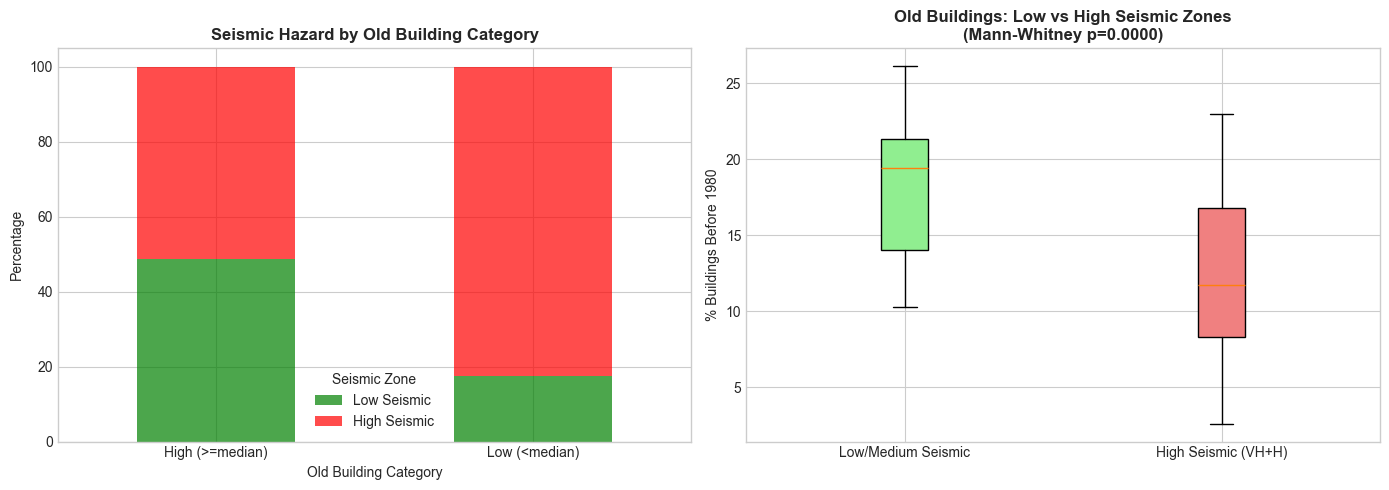

In [17]:
print('='*70)
print('RQ-NEW-11: SAFETY RISK ANALYSIS')
print('='*70)

# Create old building category (above/below median)
median_old = building_df['pct_before_1980'].median()
building_df['old_building_cat'] = np.where(building_df['pct_before_1980'] >= median_old, 'High (>=median)', 'Low (<median)')

print(f"\nMedian % old buildings: {median_old:.2f}%")

# Contingency table
contingency = pd.crosstab(building_df['old_building_cat'], building_df['high_seismic'])
contingency.columns = ['Low Seismic', 'High Seismic']
print("\n--- Contingency Table ---")
print(contingency)

# Chi-square test
chi2, p_chi, dof, expected = stats.chi2_contingency(contingency)
print(f"\n--- Chi-square Test ---")
print(f"Chi² = {chi2:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p_chi:.4f}")
print(f"Conclusion: {'Significant association' if p_chi < 0.05 else 'No significant association'} (α=0.05)")

# Mann-Whitney U test
high_seismic_old = building_df[building_df['high_seismic'] == 1]['pct_before_1980']
low_seismic_old = building_df[building_df['high_seismic'] == 0]['pct_before_1980']

u_stat, p_mw = stats.mannwhitneyu(high_seismic_old, low_seismic_old, alternative='two-sided')
print(f"\n--- Mann-Whitney U Test ---")
print(f"High seismic zones (n={len(high_seismic_old)}): mean={high_seismic_old.mean():.2f}%, median={high_seismic_old.median():.2f}%")
print(f"Low seismic zones (n={len(low_seismic_old)}): mean={low_seismic_old.mean():.2f}%, median={low_seismic_old.median():.2f}%")
print(f"U-statistic: {u_stat:.0f}")
print(f"P-value: {p_mw:.4f}")

# Point-biserial correlation
r_pb, p_pb = stats.pointbiserialr(building_df['high_seismic'], building_df['pct_before_1980'])
print(f"\n--- Point-Biserial Correlation ---")
print(f"r = {r_pb:.4f}")
print(f"P-value: {p_pb:.4f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar chart
ax1 = axes[0]
contingency_pct = contingency.div(contingency.sum(axis=1), axis=0) * 100
contingency_pct.plot(kind='bar', stacked=True, ax=ax1, color=['green', 'red'], alpha=0.7)
ax1.set_xlabel('Old Building Category')
ax1.set_ylabel('Percentage')
ax1.set_title('Seismic Hazard by Old Building Category', fontweight='bold')
ax1.legend(title='Seismic Zone')
ax1.tick_params(axis='x', rotation=0)

# Box plot comparison
ax2 = axes[1]
bp = ax2.boxplot([low_seismic_old, high_seismic_old], labels=['Low/Medium Seismic', 'High Seismic (VH+H)'],
                  patch_artist=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
ax2.set_ylabel('% Buildings Before 1980')
ax2.set_title(f'Old Buildings: Low vs High Seismic Zones\n(Mann-Whitney p={p_mw:.4f})', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'rq11_old_buildings_hazard.png'), dpi=300, bbox_inches='tight')
plt.show()

---
## 13. RQ-NEW-12: Combined Seismic Vulnerability

**Question:** "Do provinces with older housing stock overlap with provinces that have high liquefaction risk OR high seismic hazard?"

**Method:** Logistic regression + Chi-square test

**Combined Risk:** High seismic hazard (VH/H) OR High liquefaction risk (VH/H)

RQ-NEW-12: COMBINED SEISMIC VULNERABILITY

--- Risk Category Distribution ---
High Seismic Hazard: 54 provinces
High Liquefaction Risk: 11 provinces
Combined High Risk (OR): 54 provinces

Breakdown:
  Both risks: 11
  Only seismic: 43
  Only liquefaction: 0
  Neither: 27

--- % Old Buildings by Combined Risk ---
           count   mean   std  median
Low Risk      27  18.13  4.27   19.41
High Risk     54  12.50  5.18   11.75

--- Contingency Table ---
                  Low Risk  High Risk
old_building_cat                     
High (>=median)         20         21
Low (<median)            7         33

--- Chi-square Test ---
Chi² = 7.5629, df = 1, p = 0.0060

--- Logistic Regression: Combined Risk ~ % Old Buildings ---
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.2799      1.007      4.249      0.000       2.306       6.254
pct_before_1980    -

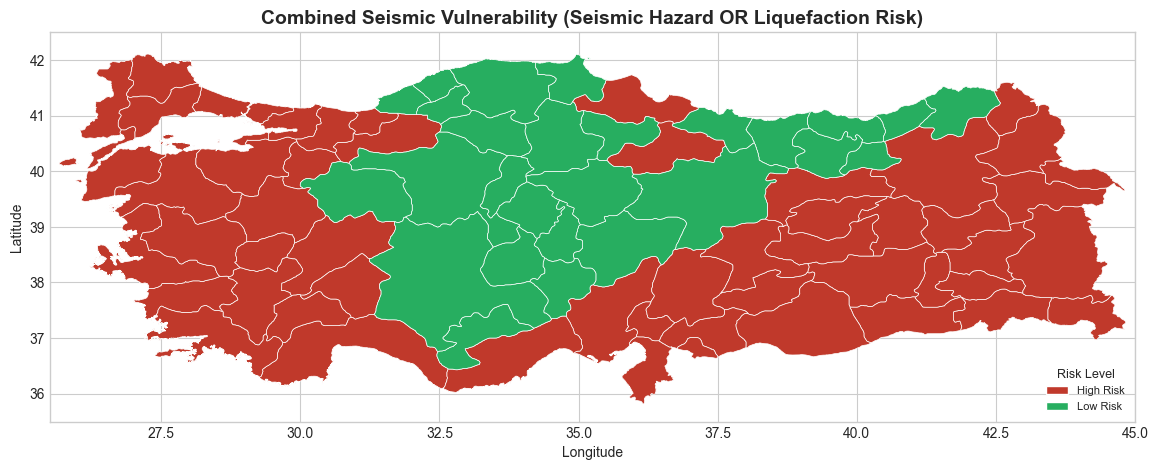

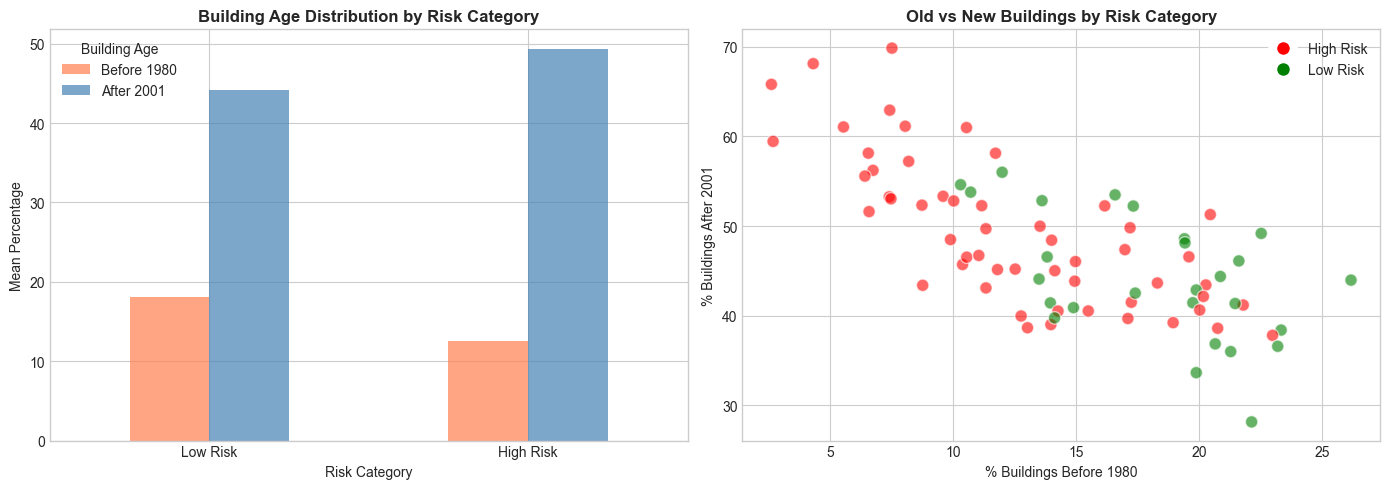

In [18]:
print('='*70)
print('RQ-NEW-12: COMBINED SEISMIC VULNERABILITY')
print('='*70)

# Create high liquefaction indicator
building_df['high_liquefaction'] = building_df['liquefaction_risk'].isin(['Very High', 'High']).astype(int)

# Combined high risk (seismic OR liquefaction)
building_df['high_risk_combined'] = ((building_df['high_seismic'] == 1) | 
                                      (building_df['high_liquefaction'] == 1)).astype(int)

print("\n--- Risk Category Distribution ---")
print(f"High Seismic Hazard: {building_df['high_seismic'].sum()} provinces")
print(f"High Liquefaction Risk: {building_df['high_liquefaction'].sum()} provinces")
print(f"Combined High Risk (OR): {building_df['high_risk_combined'].sum()} provinces")

# Venn-style breakdown
both = ((building_df['high_seismic'] == 1) & (building_df['high_liquefaction'] == 1)).sum()
only_seismic = ((building_df['high_seismic'] == 1) & (building_df['high_liquefaction'] == 0)).sum()
only_liq = ((building_df['high_seismic'] == 0) & (building_df['high_liquefaction'] == 1)).sum()
neither = ((building_df['high_seismic'] == 0) & (building_df['high_liquefaction'] == 0)).sum()

print(f"\nBreakdown:")
print(f"  Both risks: {both}")
print(f"  Only seismic: {only_seismic}")
print(f"  Only liquefaction: {only_liq}")
print(f"  Neither: {neither}")

# Descriptive stats
print("\n--- % Old Buildings by Combined Risk ---")
risk_stats = building_df.groupby('high_risk_combined')['pct_before_1980'].agg(['count', 'mean', 'std', 'median'])
risk_stats.index = ['Low Risk', 'High Risk']
print(risk_stats.round(2))

# Chi-square test
contingency = pd.crosstab(building_df['old_building_cat'], building_df['high_risk_combined'])
contingency.columns = ['Low Risk', 'High Risk']
print("\n--- Contingency Table ---")
print(contingency)

chi2, p_chi, dof, expected = stats.chi2_contingency(contingency)
print(f"\n--- Chi-square Test ---")
print(f"Chi² = {chi2:.4f}, df = {dof}, p = {p_chi:.4f}")

# Logistic Regression: combined_risk ~ pct_before_1980
print("\n--- Logistic Regression: Combined Risk ~ % Old Buildings ---")
X = sm.add_constant(building_df[['pct_before_1980']])
y = building_df['high_risk_combined']

logit_model = sm.Logit(y, X).fit(disp=0)
print(logit_model.summary().tables[1])

# Odds ratio
odds_ratio = np.exp(logit_model.params['pct_before_1980'])
ci = np.exp(logit_model.conf_int().loc['pct_before_1980'])
print(f"\nOdds Ratio: {odds_ratio:.4f} (95% CI: {ci[0]:.4f}-{ci[1]:.4f})")
print(f"P-value: {logit_model.pvalues['pct_before_1980']:.4f}")

# Figure 1: Combined risk choropleth map
building_df['risk_category'] = building_df['high_risk_combined'].map({0: 'Low Risk', 1: 'High Risk'})
risk_colors = {
    'High Risk': '#c0392b',
    'Low Risk': '#27ae60'
}
fig1, ax1 = plot_province_categories(
    building_df,
    category_column='risk_category',
    province_column='province',
    color_map=risk_colors,
    figsize=(14, 9),
    title='Combined Seismic Vulnerability (Seismic Hazard OR Liquefaction Risk)',
    legend_title='Risk Level'
)
plt.savefig(os.path.join(OUTPUT_DIR, 'rq12_combined_risk_map.png'), dpi=300, bbox_inches='tight')
plt.show()

# Figure 2: Bar chart and scatter plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Grouped bar chart
ax1 = axes[0]
risk_comparison = building_df.groupby('high_risk_combined')[['pct_before_1980', 'pct_after_2001']].mean()
risk_comparison.index = ['Low Risk', 'High Risk']
risk_comparison.columns = ['Before 1980', 'After 2001']
risk_comparison.plot(kind='bar', ax=ax1, color=['coral', 'steelblue'], alpha=0.7)
ax1.set_xlabel('Risk Category')
ax1.set_ylabel('Mean Percentage')
ax1.set_title('Building Age Distribution by Risk Category', fontweight='bold')
ax1.tick_params(axis='x', rotation=0)
ax1.legend(title='Building Age')

# Scatter plot with risk coloring
ax2 = axes[1]
colors = building_df['high_risk_combined'].map({0: 'green', 1: 'red'})
ax2.scatter(building_df['pct_before_1980'], building_df['pct_after_2001'], 
            c=colors, alpha=0.6, s=80, edgecolors='white')
ax2.set_xlabel('% Buildings Before 1980')
ax2.set_ylabel('% Buildings After 2001')
ax2.set_title('Old vs New Buildings by Risk Category', fontweight='bold')

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='High Risk'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Low Risk')]
ax2.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'rq12_combined_vulnerability.png'), dpi=300, bbox_inches='tight')
plt.show()

---
## 14. RQ-NEW-13: Earthquake Frequency vs Building Age

**Question:** "Is the frequency of major earthquakes (M≥4) in a province associated with the proportion of old buildings?"

**Method:** Poisson/Negative Binomial Regression + Spearman Correlation

**Hypothesis:** Provinces with more old buildings may have higher historical earthquake counts (due to fault proximity or geological factors)

RQ-NEW-13: EARTHQUAKE FREQUENCY VS BUILDING AGE



Provinces with major earthquakes: 77

--- Earthquake Frequency Summary ---
Total provinces: 81
Provinces with major EQs: 76
Mean major EQ count: 48.23
Max major EQ count: 577

--- Spearman Correlation ---
Spearman rho: -0.3317
P-value: 0.0025

--- Poisson Regression: EQ Count ~ % Old Buildings ---
Coefficient: -0.0480
P-value: 0.0000
Rate Ratio: 0.9532
Overdispersion ratio: 167.52

Overdispersion detected, fitting Negative Binomial...
NB Coefficient: -0.0755
NB P-value: 0.0002


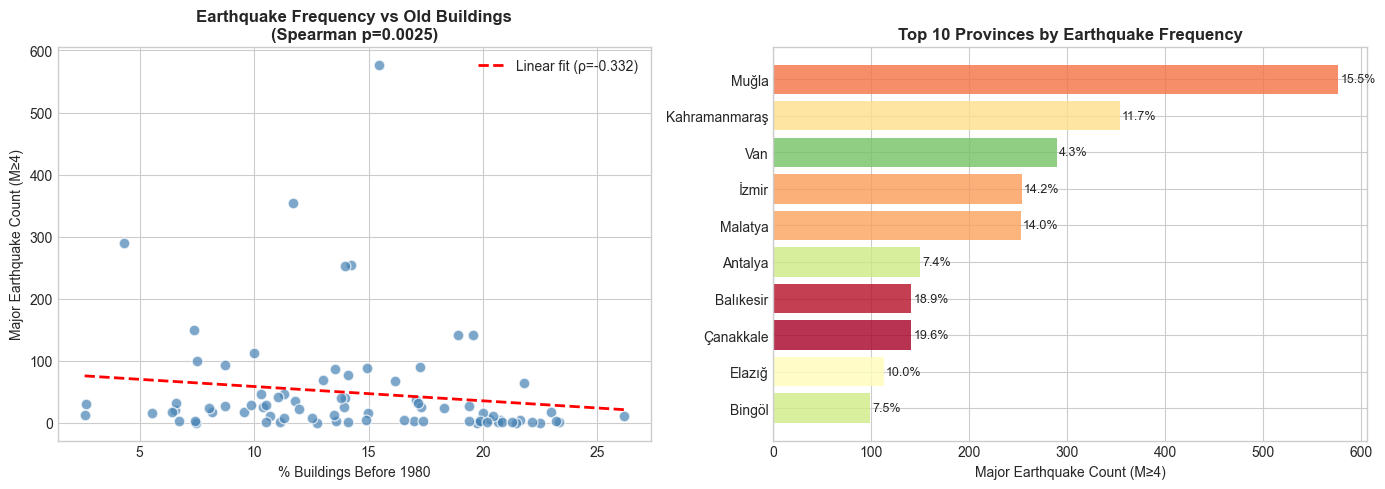

In [19]:
print('='*70)
print('RQ-NEW-13: EARTHQUAKE FREQUENCY VS BUILDING AGE')
print('='*70)

# Load earthquake data for province-level frequency
eq_df = pd.read_csv(os.path.join(DATA_PROCESSED, 'earthquakes_processed.csv'), low_memory=False)
eq_df['province'] = eq_df['province'].str.strip()

# Count major earthquakes (M >= 4) by province
major_eq_counts = eq_df[eq_df['magnitude'] >= 4.0].groupby('province').size().reset_index(name='major_eq_count')
print(f"\nProvinces with major earthquakes: {len(major_eq_counts)}")

# Merge with building data
building_eq = building_df.merge(major_eq_counts, on='province', how='left')
building_eq['major_eq_count'] = building_eq['major_eq_count'].fillna(0).astype(int)

print(f"\n--- Earthquake Frequency Summary ---")
print(f"Total provinces: {len(building_eq)}")
print(f"Provinces with major EQs: {(building_eq['major_eq_count'] > 0).sum()}")
print(f"Mean major EQ count: {building_eq['major_eq_count'].mean():.2f}")
print(f"Max major EQ count: {building_eq['major_eq_count'].max()}")

# Spearman correlation
rho_eq, p_eq = stats.spearmanr(building_eq['pct_before_1980'], building_eq['major_eq_count'])
print(f"\n--- Spearman Correlation ---")
print(f"Spearman rho: {rho_eq:.4f}")
print(f"P-value: {p_eq:.4f}")

# Poisson Regression
print("\n--- Poisson Regression: EQ Count ~ % Old Buildings ---")
X = sm.add_constant(building_eq[['pct_before_1980']])
y = building_eq['major_eq_count']

try:
    poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
    print(f"Coefficient: {poisson_model.params['pct_before_1980']:.4f}")
    print(f"P-value: {poisson_model.pvalues['pct_before_1980']:.4f}")
    print(f"Rate Ratio: {np.exp(poisson_model.params['pct_before_1980']):.4f}")
    
    # Check overdispersion
    dispersion = poisson_model.pearson_chi2 / poisson_model.df_resid
    print(f"Overdispersion ratio: {dispersion:.2f}")
    
    if dispersion > 1.5:
        print("\nOverdispersion detected, fitting Negative Binomial...")
        from statsmodels.discrete.discrete_model import NegativeBinomial
        nb_model = sm.GLM(y, X, family=sm.families.NegativeBinomial(alpha=1.0)).fit()
        print(f"NB Coefficient: {nb_model.params['pct_before_1980']:.4f}")
        print(f"NB P-value: {nb_model.pvalues['pct_before_1980']:.4f}")
except Exception as e:
    print(f"Model error: {e}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot with regression line
ax1 = axes[0]
ax1.scatter(building_eq['pct_before_1980'], building_eq['major_eq_count'], 
            c='steelblue', alpha=0.7, s=60, edgecolors='white')

# Add regression line
z = np.polyfit(building_eq['pct_before_1980'], building_eq['major_eq_count'], 1)
p = np.poly1d(z)
x_line = np.linspace(building_eq['pct_before_1980'].min(), building_eq['pct_before_1980'].max(), 100)
ax1.plot(x_line, p(x_line), 'r--', linewidth=2, label=f'Linear fit (ρ={rho_eq:.3f})')

ax1.set_xlabel('% Buildings Before 1980')
ax1.set_ylabel('Major Earthquake Count (M≥4)')
ax1.set_title(f'Earthquake Frequency vs Old Buildings\n(Spearman p={p_eq:.4f})', fontweight='bold')
ax1.legend()

# Bar chart - top 10 provinces by EQ count
ax2 = axes[1]
top10 = building_eq.nlargest(10, 'major_eq_count')[['province', 'major_eq_count', 'pct_before_1980']]
colors = plt.cm.RdYlGn_r(top10['pct_before_1980'] / top10['pct_before_1980'].max())
bars = ax2.barh(range(len(top10)), top10['major_eq_count'], color=colors, alpha=0.8)
ax2.set_yticks(range(len(top10)))
ax2.set_yticklabels(top10['province'])
ax2.set_xlabel('Major Earthquake Count (M≥4)')
ax2.set_title('Top 10 Provinces by Earthquake Frequency', fontweight='bold')
ax2.invert_yaxis()

# Add % old building labels
for i, (_, row) in enumerate(top10.iterrows()):
    ax2.text(row['major_eq_count'] + 2, i, f'{row["pct_before_1980"]:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'rq13_eq_frequency_building_age.png'), dpi=300, bbox_inches='tight')
plt.show()

---
## 15. RQ-NEW-14: Fault Proximity and Building Age

**Question:** "Are provinces closer to major fault zones more likely to have older buildings?"

**Method:** Spearman Correlation + Linear Regression

**Hypothesis:** Provinces near faults may have older infrastructure due to historical settlement patterns or slower modernization

RQ-NEW-14: FAULT PROXIMITY AND BUILDING AGE

Provinces with fault distance data: 82
Merged records: 76

--- Fault Distance Summary ---
Mean fault distance: 103.42 km
Median fault distance: 86.97 km
Range: 20.57 - 334.52 km

--- Spearman Correlation ---
Spearman rho: 0.1286
P-value: 0.2682

--- Pearson Correlation ---
Pearson r: 0.1841
P-value: 0.1113

--- Linear Regression: % Old Buildings ~ Fault Distance ---
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  12.5545      1.208     10.394      0.000      10.148      14.961
mean_fault_distance     0.0161      0.010      1.611      0.111      -0.004       0.036

R²: 0.0339

--- % Old Buildings by Fault Proximity ---
                 count   mean   std
fault_proximity                    
<20km                0    NaN   NaN
20-40km              9  14.62  7.32
40-60km             11  13.90  4.5

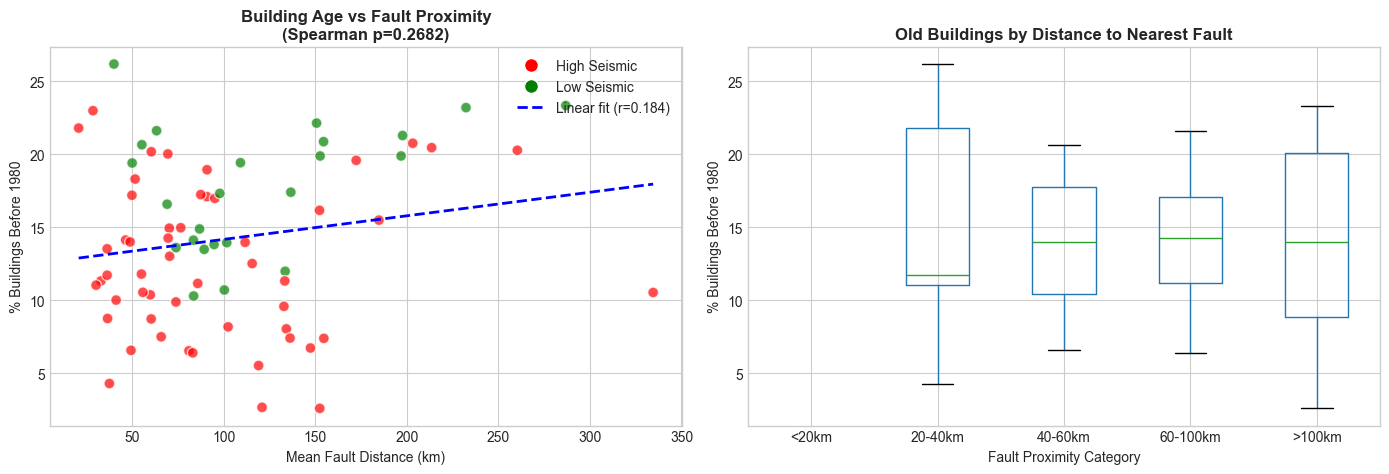


--- Interpretation ---
Not significant: No association between building age and fault proximity


In [20]:
print('='*70)
print('RQ-NEW-14: FAULT PROXIMITY AND BUILDING AGE')
print('='*70)

# Calculate mean fault distance by province
fault_by_province = eq_df.groupby('province')['fault_distance_km'].mean().reset_index()
fault_by_province.columns = ['province', 'mean_fault_distance']
print(f"\nProvinces with fault distance data: {len(fault_by_province)}")

# Merge with building data
building_fault = building_df.merge(fault_by_province, on='province', how='left')
building_fault = building_fault.dropna(subset=['mean_fault_distance'])
print(f"Merged records: {len(building_fault)}")

# Descriptive stats
print(f"\n--- Fault Distance Summary ---")
print(f"Mean fault distance: {building_fault['mean_fault_distance'].mean():.2f} km")
print(f"Median fault distance: {building_fault['mean_fault_distance'].median():.2f} km")
print(f"Range: {building_fault['mean_fault_distance'].min():.2f} - {building_fault['mean_fault_distance'].max():.2f} km")

# Spearman correlation
rho_fault, p_fault = stats.spearmanr(building_fault['mean_fault_distance'], building_fault['pct_before_1980'])
print(f"\n--- Spearman Correlation ---")
print(f"Spearman rho: {rho_fault:.4f}")
print(f"P-value: {p_fault:.4f}")

# Pearson correlation
r_pearson, p_pearson = stats.pearsonr(building_fault['mean_fault_distance'], building_fault['pct_before_1980'])
print(f"\n--- Pearson Correlation ---")
print(f"Pearson r: {r_pearson:.4f}")
print(f"P-value: {p_pearson:.4f}")

# Linear Regression
print("\n--- Linear Regression: % Old Buildings ~ Fault Distance ---")
X = sm.add_constant(building_fault[['mean_fault_distance']])
y = building_fault['pct_before_1980']

ols_model = sm.OLS(y, X).fit()
print(ols_model.summary().tables[1])
print(f"\nR²: {ols_model.rsquared:.4f}")

# Create distance categories for additional analysis
building_fault['fault_proximity'] = pd.cut(building_fault['mean_fault_distance'], 
                                           bins=[0, 20, 40, 60, 100, np.inf],
                                           labels=['<20km', '20-40km', '40-60km', '60-100km', '>100km'])

print("\n--- % Old Buildings by Fault Proximity ---")
prox_stats = building_fault.groupby('fault_proximity')['pct_before_1980'].agg(['count', 'mean', 'std'])
print(prox_stats.round(2))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter with regression line
ax1 = axes[0]
colors = building_fault['high_seismic'].map({0: 'green', 1: 'red'})
ax1.scatter(building_fault['mean_fault_distance'], building_fault['pct_before_1980'], 
            c=colors, alpha=0.7, s=60, edgecolors='white')

# Add regression line
z = np.polyfit(building_fault['mean_fault_distance'], building_fault['pct_before_1980'], 1)
p = np.poly1d(z)
x_line = np.linspace(building_fault['mean_fault_distance'].min(), building_fault['mean_fault_distance'].max(), 100)
ax1.plot(x_line, p(x_line), 'b--', linewidth=2, label=f'Linear fit (r={r_pearson:.3f})')

ax1.set_xlabel('Mean Fault Distance (km)')
ax1.set_ylabel('% Buildings Before 1980')
ax1.set_title(f'Building Age vs Fault Proximity\n(Spearman p={p_fault:.4f})', fontweight='bold')
ax1.legend()

# Add legend for colors
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='High Seismic'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Low Seismic')]
ax1.legend(handles=legend_elements + [ax1.get_lines()[0]], loc='upper right')

# Box plot by proximity category
ax2 = axes[1]
building_fault.boxplot(column='pct_before_1980', by='fault_proximity', ax=ax2)
ax2.set_xlabel('Fault Proximity Category')
ax2.set_ylabel('% Buildings Before 1980')
ax2.set_title('Old Buildings by Distance to Nearest Fault', fontweight='bold')
plt.suptitle('')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'rq14_fault_proximity_building_age.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print interpretation
print("\n--- Interpretation ---")
if p_fault < 0.05:
    direction = "closer to" if rho_fault < 0 else "farther from"
    print(f"SIGNIFICANT: Provinces with older buildings tend to be {direction} major fault zones")
else:
    print("Not significant: No association between building age and fault proximity")

---
## 16. Summary of All New Research Questions

In [21]:
# Create summary table
print('='*70)
print('SUMMARY OF NEW RESEARCH QUESTIONS')
print('='*70)

summary_results = [
    ['RQ-NEW-1', 'Eclipse vs Non-Eclipse Rate', "Fisher's Exact Test", f'p={fisher_pvalue:.4f}', 'Yes' if fisher_pvalue < 0.05 else 'No'],
    ['RQ-NEW-2', 'Eclipse Magnitude Effect', 'Poisson/NB Regression', 'See above', '-'],
    ['RQ-NEW-3', 'Moon Illumination Effect', 'Poisson Regression', f'p={model_linear.pvalues[1]:.4f}' if aic_linear != np.inf else 'N/A', 'Yes' if aic_linear != np.inf and model_linear.pvalues[1] < 0.05 else 'No'],
    ['RQ-NEW-4', 'Time-of-Day Uniformity', 'Chi-square + SR', f'p={p_value:.4e}', 'Yes' if p_value < 0.05 else 'No'],
    ['RQ-NEW-5', 'Seasonal Uniformity', 'Chi-square + SR', f'p={p_value_season:.4e}', 'Yes' if p_value_season < 0.05 else 'No'],
    ['RQ-NEW-6', 'Magnitude Predictors', 'Multiple Regression', f'R²={model_full.rsquared:.4f}' if 'model_full' in dir() else 'N/A', '-'],
    ['RQ-NEW-7', 'Near-Fault Effects', 'Multiple Regression', f'R²={model_near.rsquared:.4f}' if 'model_near' in dir() else 'N/A', '-'],
    ['RQ-NEW-8', 'High Risk Overlap', 'Logistic + VIF', 'See above', '-'],
    ['RQ-NEW-9', 'Regional Building Age', 'Kruskal-Wallis + Dunn', 'See above', '-'],
    ['RQ-NEW-10', 'EQ Vulnerability (Building Age)', 'Logistic Regression', 'See above', '-'],
    ['RQ-NEW-11', 'Safety Risk (Old Buildings)', 'Chi-square + Mann-Whitney', 'See above', '-'],
    ['RQ-NEW-12', 'Combined Vulnerability', 'Logistic Regression', 'See above', '-'],
    ['RQ-NEW-13', 'EQ Frequency vs Building Age', 'Poisson/NB + Spearman', 'See above', '-'],
    ['RQ-NEW-14', 'Fault Proximity + Building Age', 'Spearman + OLS', 'See above', '-']
]

summary_df = pd.DataFrame(summary_results, columns=['RQ', 'Question', 'Test', 'Result', 'Significant'])
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv(os.path.join(TABLES_PATH, 'new_rqs_summary.csv'), index=False)
print(f'\nSummary saved to: {os.path.join(TABLES_PATH, "new_rqs_summary.csv")}')

SUMMARY OF NEW RESEARCH QUESTIONS
       RQ                        Question                      Test       Result Significant
 RQ-NEW-1     Eclipse vs Non-Eclipse Rate       Fisher's Exact Test     p=0.4484          No
 RQ-NEW-2        Eclipse Magnitude Effect     Poisson/NB Regression    See above           -
 RQ-NEW-3        Moon Illumination Effect        Poisson Regression     p=0.0000         Yes
 RQ-NEW-4          Time-of-Day Uniformity           Chi-square + SR p=6.6823e-06         Yes
 RQ-NEW-5             Seasonal Uniformity           Chi-square + SR p=1.2127e-46         Yes
 RQ-NEW-6            Magnitude Predictors       Multiple Regression    R²=0.0067           -
 RQ-NEW-7              Near-Fault Effects       Multiple Regression    R²=0.0129           -
 RQ-NEW-8               High Risk Overlap            Logistic + VIF    See above           -
 RQ-NEW-9           Regional Building Age     Kruskal-Wallis + Dunn    See above           -
RQ-NEW-10 EQ Vulnerability (Building

In [22]:
print('\n' + '='*70)
print('NEW RESEARCH QUESTIONS ANALYSIS COMPLETE')
print('='*70)
print(f'\nFigures saved to: {OUTPUT_DIR}')
print(f'Tables saved to: {TABLES_PATH}')


NEW RESEARCH QUESTIONS ANALYSIS COMPLETE

Figures saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/figures/17_new_rqs
Tables saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables
